In [1]:
import pdb
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from ipywidgets import widgets, Checkbox, FloatSlider, IntSlider, IntRangeSlider, FloatRangeSlider, RadioButtons
from IPython.core.display import clear_output, display
%matplotlib inline

# Calibrate

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../calibration-elp-final/WIN*.jpg')[0:9]

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
#         cv2.imshow('img', img)
#         cv2.waitKey(500)

cv2.destroyAllWindows()

print("Number of calibration images: {}".format(len(images)))
print(images)

Number of calibration images: 9
['../calibration-elp-final/WIN_20170604_18_18_01_Pro.jpg', '../calibration-elp-final/WIN_20170604_18_19_00_Pro.jpg', '../calibration-elp-final/WIN_20170606_02_25_41_Pro.jpg', '../calibration-elp-final/WIN_20170604_18_17_12_Pro.jpg', '../calibration-elp-final/WIN_20170604_18_18_55_Pro.jpg', '../calibration-elp-final/WIN_20170606_02_28_01_Pro.jpg', '../calibration-elp-final/WIN_20170606_02_24_43_Pro.jpg', '../calibration-elp-final/WIN_20170604_18_16_51_Pro.jpg', '../calibration-elp-final/WIN_20170606_02_27_55_Pro.jpg']


Return of calibrate camera: 0.26600119293689817


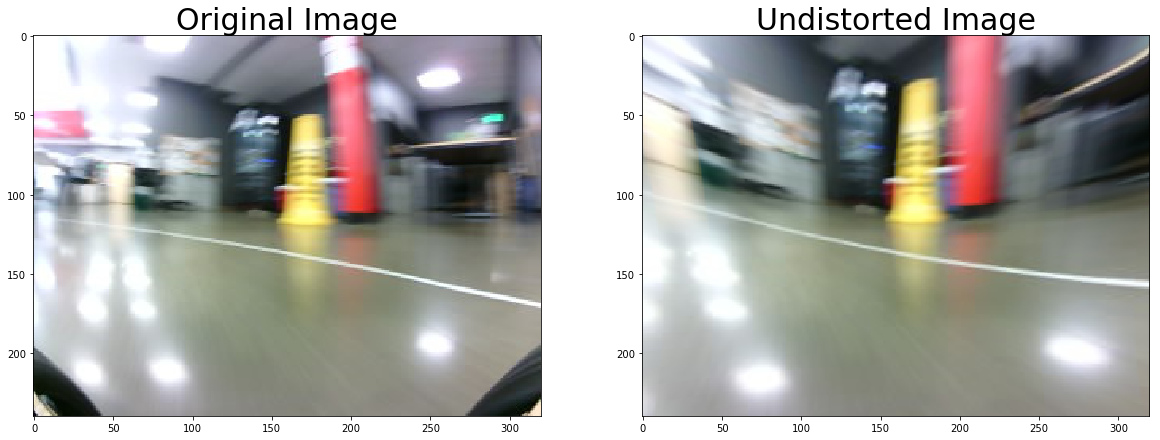

In [3]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('test_images/turning.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

print("Return of calibrate camera: {}".format(ret))
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration-elp-final/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "../calibration-elp-final/cal-elp.p", "wb" ) )
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# Perspective Transform

In [4]:
img.shape

(240, 320, 3)

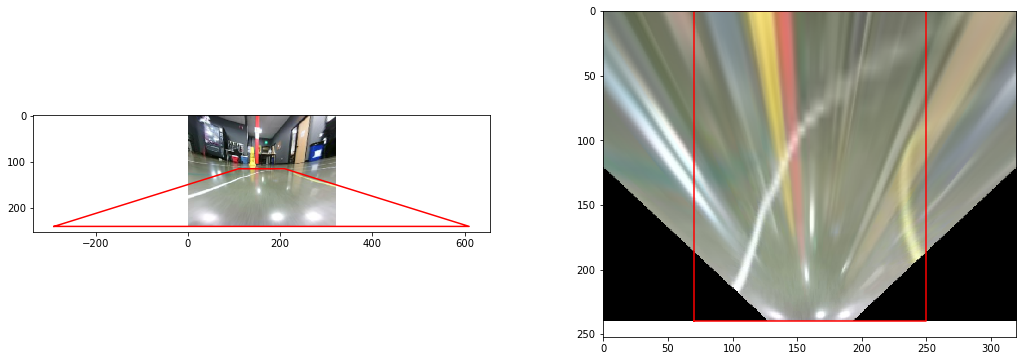

In [5]:
fig = plt.figure(figsize=(18, 6))

img = cv2.imread('test_images/middle.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


img_size = (img.shape[1], img.shape[0])

top_width = 100
left_top = (img_size[0] - top_width) / 2
right_top = left_top + top_width
bottom_width = 900
left_bottom = (img_size[0] - bottom_width) / 2
right_bottom = left_bottom + bottom_width
top = 115
bottom = 240

src = np.float32([[left_bottom,bottom],
                 [left_top,top],
                 [right_top,top],
                 [right_bottom,bottom]])

width = 180
left = (img_size[0] - width) / 2
right = left + width
top = 0
bottom = 240
dst = np.float32([[left,bottom],
                 [left,top],
                 [right,top],
                 [right,bottom]])

a = fig.add_subplot(1, 2, 1)
undist_img = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undist_img)
a.plot(np.append(src[:,0],src[0,0]), np.append(src[:,1],src[0,1]), '-r')

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(undist_img, M, img_size)

a = fig.add_subplot(1, 2, 2)
plt.imshow(warped)
_ = a.plot(np.append(dst[:,0],dst[0,0]), np.append(dst[:,1],dst[0,1]), '-r')

# Reflections removal

See "Reflection Removal" notebook document.

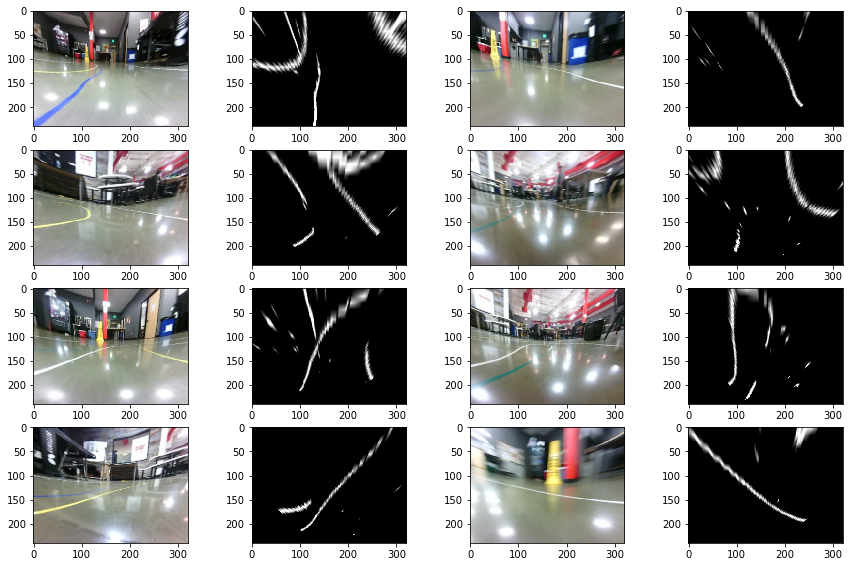

In [6]:
img_paths = glob.glob('test_images/*.jpg')
fig = plt.figure(figsize=(15, 20))
cols = 4
rows = len(img_paths)
i = 1

def preprocess(img_raw, mtx, dist, M):
    img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2HSV)[:, :, 1]
    img = cv2.Sobel(img, -1, 1, 0, ksize=3)
    img = img > 127
    
    img1 = cv2.cvtColor(img_raw, cv2.COLOR_BGR2HSV)[:, :, 2]
    img1 = cv2.Sobel(img1, -1, 0, 1, ksize=3)
    img1 = img1 > 127
    
    img2 = cv2.cvtColor(img_raw, cv2.COLOR_BGR2HSV)
    img2 = cv2.inRange(img2, (38, 61, 112), (139, 255, 255))
    img2 = img2 > 25.5

    final_img = (img==1) | (img1==1) | (img2==1)
    
    f3 = np.stack((final_img, final_img, final_img), axis=2)
    f3 = (f3 * 255.0).astype(np.uint8)

    undist = cv2.undistort(f3, mtx, dist, None, mtx)
    warped = cv2.warpPerspective(undist, M, img_size)
    return warped[:, :, 0]

for img_path in img_paths:
    ax = fig.add_subplot(rows, cols, i)
    img_raw = cv2.imread(img_path)
    img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
#     warped = cv2.warpPerspective(undist, M, img_size)
    plt.imshow(undist)
    i += 1

    ax = fig.add_subplot(rows, cols, i)
    warped = preprocess(img_raw, mtx, dist, M)
    plt.imshow(warped, cmap='gray')
    i += 1

# Histogram

In [7]:
importance = 1
weights = np.array([range(5)])*importance
print(weights.T)
x = np.array([[0, 1, 1, 0, 1, 0],
              [0, 1, 1, 1, 0, 1],
              [0, 0, 1, 0, 1, 1],
              [0, 1, 1, 1, 0, 0],
              [1, 1, 0, 1, 1, 0]])
x = weights.T ** x
print(x)

# For center weights, convert as follows:
# 0 1 2 3 4 5 6 7 to 1 2 3 4 4 3 2 1
# (changes: 1, 1, 1, 1, 0, -2, -4. -6)
# In other words, points closer to the center have higher scores.

cweights = np.array([range(6)])
hlen = int(cweights.shape[1]/2) # half-length
adj = [1] * hlen # adjustments
for i in range(hlen):
    v = -i*6
    adj.append(v)
cweights += adj
print(cweights)
x += cweights
print(x)
histogram = np.sum(x[1:,:], axis=0)
histogram

[[0]
 [1]
 [2]
 [3]
 [4]]
[[1 0 0 1 0 1]
 [1 1 1 1 1 1]
 [1 1 2 1 2 2]
 [1 3 3 3 1 1]
 [4 4 1 4 4 1]]
[[ 1  2  3  3 -2 -7]]
[[ 2  2  3  4 -2 -6]
 [ 2  3  4  4 -1 -6]
 [ 2  3  5  4  0 -5]
 [ 2  5  6  6 -1 -6]
 [ 5  6  4  7  2 -6]]


array([ 11,  17,  19,  21,   0, -23])

In [8]:
def annotate_with_lines(background, lines, keep_background=True):
    """ Annotate a background with lines. """    
    ploty = [i for i in range(background.shape[0])]
    # Create an image to draw the lines on
    if keep_background:
        canvas = np.array(background, dtype=np.uint8)
    else:
        canvas = np.zeros_like(background).astype(np.uint8)

    # If grey image, convert to three channels
    if len(canvas.shape) == 2 or canvas.shape[2] == 1:
        canvas = np.stack((canvas, canvas, canvas), axis=2)
        canvas = (canvas * 255.0).astype(np.uint8)
    
    if 'left' in lines:
        for line in lines['left']:
            if line is not None:
                fitx = line['x']
                pts = np.array([np.transpose(np.vstack([fitx, ploty]))], np.int32)
                cv2.polylines(canvas, np.int_([pts]), False, (255, 255, 0), thickness=3)
            
    if 'right' in lines:
        for line in lines['right']:
            if line is not None:
                fitx = line['x']
                pts = np.array([np.transpose(np.vstack([fitx, ploty]))], np.int32)
                cv2.polylines(canvas, np.int_([pts]), False, (0, 255, 0), thickness=3)

    return canvas

def calc_error(fitx, nonzero, width_total, max_distance=170, top_percentile=75, debug=False):
    """ Calculate the similarity score of line positions and activated pixels.
    
    Error count is MSE.
    Args:
        fitx: The line's x value for each y position.
        nonzero: Non-zero pixels produced by np.nonzero() method.
        width: Image width. Do not count pixels outside the image.
    """
   # Identify the x and y positions of all nonzero pixels in the image
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    total_error = 0
    counter = 0
    if debug:
        print("start error calculation")
    errors =[]
    for y, x in enumerate(fitx):
        # Do not count pixels outside the image.
        if x < 0 or x >= width_total:
            continue
        min_error = None
        line_x = None
        if debug:
            print("y={}".format(y))
        # Indexes of active pixels where y == some value
        for [i] in np.argwhere(nonzeroy==y):
            # Compare the line's x with the pixel's.
            line_x = nonzerox[i]
            error = ((line_x - x)**2)**0.5
            if (min_error is None or error < min_error):
                min_error = error
                
        if min_error is not None:
            errors.append(min_error)
            
        if debug:
            print("line x = {}, point x = {}, error = {}".format(x, line_x, min_error))

    errors = np.array(errors)
    perc = np.percentile(errors, top_percentile)
    if debug:
        print("Remove errors higher than",perc)
    errors = errors[np.where(errors < perc)]
        
    return np.mean(errors)


In [9]:
class FindLinesSlidingWindows(object):
    def __init__(self,
                 debug=False, debug_dir=None, debug_show_lines=False,
                 debug_error_detail=False,
                 nwindows=20,
                 window_minpix=50,
                 error_top_percentile=70,
                 error_threshold=50000,
                 window_patience=2,
                 window_empty_px=4,
                 center_importance=2,
                 crop_top=0.4,
                 lr_start_slack=0.2,
                 subsequent_search_margin=30, always_recalculate=False):
        """ Initialize a Sliding Window line finder.
        
        When `debug` is True, add the following before running the `process()` method:
        >>> fig = plt.figure(figsize=(18, 48))
        >>> a = fig.add_subplot(1, 1, 1)

        Args:
            debug_dir: Set to 'v', 'h', or None. Combined with `debug==True` this will show the sliding windows.
            window_patience: Maximum number of windows with n pixels < window_min_threshold before
                             giving up.
            window_empty_px: Number of pixels inside a window must be larger than this to be considered
                             as non-empty.
            crop_top: When doing horizontal search, do not include a portion of the top section defined by this
                      parameter.
            error_top_percentile: Remove errors higher than this percentile.
                            This is used to remove outlier errors caused by missing lines and not fitting issue.
            lr_start_slack: Left and right lines must come from the edge + this slack * width
        """
        self.reset()     
        
        # Initial search windows
        self.nwindows = nwindows
        self.window_minpix = window_minpix
        
        # Subsequent search related
        self.subsequent_search_margin = subsequent_search_margin
        
        self.debug = debug
        self.debug_dir = debug_dir
        self.debug_show_lines = debug_show_lines
        self.debug_error_detail = debug_error_detail
        
        self.error_threshold = error_threshold    
        self.window_patience = window_patience
        self.window_empty_px = window_empty_px
        self.crop_top = crop_top
        self.lr_start_slack = lr_start_slack
        self.binary_warped = None
        self.error_top_percentile = error_top_percentile
        self.center_importance = center_importance
    def _polyfit(self, x, y):
        # Fit a second order polynomial
        if len(y) > 0 and len(x) > 0:
            fit, error, _, _, _ = np.polyfit(y, x, 2, full=True)
            if len(error) == 0:
                error = 0
            else:
                error = error[0]
            error /= len(y)
        else:
            return None
        if all( i==0 for i in fit ):
            return None
        return (fit, error)
    
    def _calculate_v_fits(self):
        """ Find lines that run vertically on the screen.
        """
        # binary_warped shape: (height, width)
        
        binary_warped = self.binary_warped

        left_lane_inds = []
        right_lane_inds = []
        
        margin = self.subsequent_search_margin

        # Pixels closer to the car are more important, so we apply weights the histogram
        importance = 1
        weights = np.array([range(binary_warped.shape[0])])*importance
        weighted = binary_warped * weights.T
#         weighted = weights.T ** binary_warped
#         weighted = binary_warped

        # For center weights, convert as follows:
        # 0 1 2 3 4 5 6 7 to 1 2 3 4 4 3 2 1
        # (changes: 1, 1, 1, 1, 0, -2, -4. -6)
        # In other words, points closer to the center have higher scores.

        cweights = np.array([range(binary_warped.shape[1])])
        hlen = int(cweights.shape[1]/2) # half-length
        adj = [1] * hlen # adjustments
        for i in range(hlen):
            v = -i*2
            adj.append(v)
        cweights += adj
        weighted *= cweights ** self.center_importance

        # Sums all weighted points in the bottom 50% section (remember that bigger numbers are at the bottom).
#         histogram = np.sum(weighted, axis=0)
        histogram = np.sum(weighted[int(weighted.shape[0]/2):,:], axis=0)
        midpoint = np.int(histogram.shape[0]/2)
        histogram_l = histogram[:(midpoint)]
        histogram_r = histogram[(midpoint+5):]
        
        # === SLIDING WINDOWS ===
        leftx_base = np.argmax(histogram_l) - margin
        rightx_base = np.argmax(histogram_r) + midpoint + margin
        # At this point, leftx_base and rightx_base should contain x position of each respective line.
        window_height = np.int(binary_warped.shape[0]/self.nwindows)

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Only used for debugging.
        if self.debug:
            out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        
        left_patience_counter = 0
        right_patience_counter = 0
        # The window takes into account x position found in the previous
        # centroid. It finds a centroid closest to it in the next iteration of window.
        # If there is no centroid x, use window center.
        # Global coordinate is used here.
        left_window_prev_x = leftx_current
        right_window_prev_x = rightx_current
        # Step through the windows one by one
        for window in range(self.nwindows):
            # Identify window boundaries in x and y (and right and left)
            # The higher win_y_low is, the closer to the top of the plot.
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
                        
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                              (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                               (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

            
            # === Select better centroid (Left) ===
            # Find the centroids of pixels in the current window.
            connectivity = 4
            left_pixels_x = nonzerox[good_left_inds]-win_xleft_low
            left_pixels_y = nonzeroy[good_left_inds]-win_y_low
            pixels = np.zeros((window_height, (margin * 2)))

            best_centroid_x, best_pixels_pos = self._choose_best_centroid(
                pixels, leftx_current, win_xleft_low, left_pixels_x, left_pixels_y)

            if best_pixels_pos is not None:
                # Currently, best_pixels_pos contains the most relevant positions.
                # We just need to convert them into good_[left/right]_inds.
                best_pixels_pos += [win_y_low, win_xleft_low]
                bestx = best_pixels_pos[:, 1]
                besty = best_pixels_pos[:, 0]

                good_left_inds = np.intersect1d(np.argwhere(np.in1d(nonzerox,bestx)).flatten(), \
                    np.argwhere(np.in1d(nonzeroy,besty)).flatten()).tolist()
                
            # === END Select better centroid (Left)===

            # === Select better centroid (Right) ===
            # Find the centroids of pixels in the current window.
            connectivity = 4
            right_pixels_x = nonzerox[good_right_inds]-win_xright_low
            right_pixels_y = nonzeroy[good_right_inds]-win_y_low
            pixels = np.zeros((window_height, (margin * 2)))

            best_centroid_x, best_pixels_pos = self._choose_best_centroid(
                pixels, rightx_current, win_xright_low, right_pixels_x, right_pixels_y)

            if best_pixels_pos is not None:
                # Currently, best_pixels_pos contains the most relevant positions.
                # We just need to convert them into good_[left/right]_inds.
                best_pixels_pos += [win_y_low, win_xright_low]
                bestx = best_pixels_pos[:, 1]
                besty = best_pixels_pos[:, 0]

                good_right_inds = np.intersect1d(np.argwhere(np.in1d(nonzerox,bestx)).flatten(), \
                    np.argwhere(np.in1d(nonzeroy,besty)).flatten()).tolist()
                
            # === END Select better centroid (Right)===

#             right_previous_centroid_x, best_pixels_pos = self._choose_best_centroid(
#                 pixels, right_previous_centroid_x, right_pixels_x, right_pixels_y)

            # If any of the left lane pixels touches left section, stop.
            if np.any(nonzerox[good_left_inds] == 0):
                left_patience_counter = self.window_patience+1
            # If any of the right lane pixels touches right section, stop.
            if np.any(nonzerox[good_right_inds] == binary_warped.shape[1]):
                right_patience_counter = self.window_patience+1

            # If sliding windows do not find enough pixels for some iterations, give up.
            if left_patience_counter > self.window_patience:
                pass
            else:
                if len(good_left_inds) < self.window_empty_px:
                    left_patience_counter += 1
                else:
                    left_patience_counter = 0

                    # Append these indices to the lists
                    left_lane_inds.append(good_left_inds)

                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > self.window_minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))

                # === DEBUGGING SLIDING WINDOWS ===
                if self.debug:
                    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(255,0,0), 2) 
                # === END DEBUGGING SLIDING WINDOWS ===


            if right_patience_counter > self.window_patience:
                pass
            else:
                if len(good_right_inds) < self.window_empty_px:
                    right_patience_counter += 1
                else:
                    right_patience_counter = 0

                    # Append these indices to the lists
                    right_lane_inds.append(good_right_inds)

                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_right_inds) > self.window_minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                    
                # === DEBUGGING SLIDING WINDOWS ===
                if self.debug:
                    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
                # === END DEBUGGING SLIDING WINDOWS ===

        # === END SLIDING WINDOWS ===
        fits = self._wrap_up_windows(left_lane_inds, right_lane_inds, nonzerox, nonzeroy, 'v')
        
        # === DEBUGGING ===
        if self.debug:
            if self.debug_dir == 'v':
                plt.imshow(out_img, cmap='gray')
            # Normalize histogram values so they don't go beyond image height.
            maxval = np.amax(histogram)
            hist_viz = np.copy(histogram)
            if maxval != 0:
                hist_viz = (hist_viz/maxval) * binary_warped.shape[0]

            # Subtract histogram values from max values so the histogram can be drawn
            # at the bottom of the plot.
            hist_viz = binary_warped.shape[0] - hist_viz
            a.plot(hist_viz, '-', c='#00FFFF', lw=2)

        # === END DEBUGGING ===

        return (fits, histogram_l, histogram_r)

    def _calculate_h_fits(self):
        """ Find lines that run horizontally on the screen.
        """
        
        binary_warped = self.binary_warped

        # binary_warped shape: (height, width)
        left_lane_inds = []
        right_lane_inds = []

        margin = self.subsequent_search_margin
        
        # Distance to bottom edges does not mean anything in horizontal fits.
        weighted = binary_warped

        # y position needs to be flipped for left windows.
        # This was found by visualizing the result and comparing the position of
        # windows vs. histograms.

        y_start_from = int(weighted.shape[0] * self.crop_top)
        histogram_l = np.flip(np.sum(weighted[y_start_from:,:int(weighted.shape[1]/2)], axis=1), axis=0)
        histogram_r = np.sum(weighted[y_start_from:,int(weighted.shape[1]/2):], axis=1)
        
        # === SLIDING WINDOWS ===
        lefty_base = weighted.shape[0] - np.argmax(histogram_l)
        righty_base = y_start_from + np.argmax(histogram_r)
        # At this point, leftx_base and rightx_base should contain y position of each respective line.
        window_height = np.int(binary_warped.shape[1]/self.nwindows)

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Current positions to be updated for each window
        lefty_current = lefty_base
        righty_current = righty_base

        # Only used for debugging.
        if self.debug:
            out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

        left_patience_counter = 0
        right_patience_counter = 0
        # Step through the windows one by one
        for window in range(self.nwindows):
            # For right windows, low x means more right, and vice versa for left windows.
            lwin_x_low = (window)*window_height
            rwin_x_low = binary_warped.shape[1] - ((window)*window_height)
            
            # For right windows, high x means more left, and vice versa for left windows.
            lwin_x_high = (window+1)*window_height
            rwin_x_high = binary_warped.shape[1] - ((window+1)*window_height)
            
            # Bottom positions of the windows.
            lwin_y_low = lefty_current + margin
            rwin_y_low = righty_current + margin

            # Top positions of the windows.
            lwin_y_high = lefty_current - margin
            rwin_y_high = righty_current - margin
            
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy <= lwin_y_low) & (nonzeroy > lwin_y_high) & \
                              (nonzerox >= lwin_x_low) & (nonzerox < lwin_x_high)).nonzero()[0]
            good_right_inds = ((nonzeroy <= rwin_y_low) & (nonzeroy > rwin_y_high) & \
                               (nonzerox >= rwin_x_high) & (nonzerox < rwin_x_low)).nonzero()[0]
            
            # If any of the pixels touches top section, stop.
            if np.any(nonzeroy[good_right_inds] == 0):
                right_patience_counter = self.window_patience+1
            if np.any(nonzeroy[good_left_inds] == 0):
                left_patience_counter = self.window_patience+1
            
            # Debugging code. Keep for later.
#             print(nonzeroy, ">=", rwin_y_low, "&", nonzeroy, "<", rwin_y_high, "&",
#                   nonzerox, ">=", lwin_x_high, "&", nonzerox, "<", rwin_x_low)
#             print("(nonzeroy >= rwin_y_low):",np.sum(nonzeroy >= rwin_y_low))
#             print("(nonzeroy < rwin_y_high):",np.sum(nonzeroy < rwin_y_high))
#             print("(nonzerox >= rwin_x_high):",np.sum(nonzerox >= rwin_x_high))
#             print("(nonzerox < rwin_x_low):",np.sum(nonzerox < rwin_x_low))
#             print("rwin_y_low:",rwin_y_low)
#             print(len(good_right_inds))
#             (nonzeroy >= rwin_y_low).nonzero()
            
            # If sliding windows do not find enough pixels for some iterations, give up.
            if left_patience_counter > self.window_patience:
                pass
            else:
                if len(good_left_inds) < self.window_empty_px:
                    left_patience_counter += 1
                else:
                    left_patience_counter = 0

                    # Append these indices to the lists
                    left_lane_inds.append(good_left_inds)

                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > self.window_minpix:
                    lefty_current = np.int(np.mean(nonzeroy[good_left_inds]))
                
                # === DEBUGGING SLIDING WINDOWS ===
                if self.debug:
                    cv2.rectangle(out_img,(lwin_x_low,lwin_y_low),(lwin_x_high,lwin_y_high),(255,0,0), 2) 
                # === END DEBUGGING SLIDING WINDOWS ===

            if right_patience_counter > self.window_patience:
                pass
            else:
                if len(good_right_inds) < self.window_empty_px:
                    right_patience_counter += 1
                else:
                    right_patience_counter = 0

                    # Append these indices to the lists
                    right_lane_inds.append(good_right_inds)

                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_right_inds) > self.window_minpix:        
                    righty_current = np.int(np.mean(nonzeroy[good_right_inds]))

                # === DEBUGGING SLIDING WINDOWS ===
                if self.debug:
                    cv2.rectangle(out_img,(rwin_x_high,rwin_y_low),(rwin_x_low,rwin_y_high),(0,255,0), 2) 
                # === END DEBUGGING SLIDING WINDOWS ===
                    
        # === END SLIDING WINDOWS ===
        fits = self._wrap_up_windows(left_lane_inds, right_lane_inds, nonzerox, nonzeroy, 'h')
       
        # === DEBUGGING ===
        if self.debug:
            if self.debug_dir == 'h':
                plt.imshow(out_img, cmap='gray')

            # LEFT
            # Normalize histogram values so they don't go beyond half of image width.
            maxval = np.amax(histogram_l)
            hist_viz = np.copy(histogram_l)
            if maxval != 0:
                hist_viz = (hist_viz/maxval) * binary_warped.shape[1]/2

            a.plot(hist_viz, list(reversed(range(binary_warped.shape[0])[y_start_from:])), '-', c='#00FFFF', lw=2)

            # RIGHT
            # Normalize histogram values so they don't go beyond half of image width.
            maxval = np.amax(histogram_r)
            hist_viz = np.copy(histogram_r)
            if maxval != 0:
                hist_viz = (hist_viz/maxval) * binary_warped.shape[1]/2        

            # Subtract histogram values from max values so the histogram can be drawn
            # at the right side of the plot.
            hist_viz = (binary_warped.shape[1]) - hist_viz

            a.plot(hist_viz, list(range(binary_warped.shape[0])[y_start_from:]), '-', c='#00FFFF', lw=2)

        # === END DEBUGGING ===
        return (fits, histogram_l, histogram_r)
        
    def _calculate_fits(self):
        """ Try out both horizontal and vertical fits, then pick the best.
        """
        binary_warped = self.binary_warped
        
        if self.debug and self.debug_dir == None:
            plt.imshow(binary_warped, cmap='gray')
            
        # lfits[0]: vertical fits,
        # lfits[1]: horizontal_fits
        vfits, vhist_l, vhist_r = self._calculate_v_fits()
        hfits, hhist_l, hhist_r = self._calculate_h_fits()
        
        lfits = []
        rfits = []
        
        # Comment any of the following lines to debug.
        if 'left' in vfits:
            lfits.append(vfits['left'])
        if 'right' in vfits:
            rfits.append(vfits['right'])
        if 'left' in hfits:
            lfits.append(hfits['left'])
        if 'right' in hfits:
            rfits.append(hfits['right'])
        
        # Calculate mean squared error between lines and activated points.
        # Choose a line with least error for each side.
        
        midpoint = np.int(binary_warped.shape[1]/2)
        selected = {'left': [], 'right': []}

        # Do the error calculation here.
        # Threshold value found by eyeballing min_error
        # For horizontal fits calculation, use y distance.

        nonzero = binary_warped.nonzero()
        
        best = None
        min_error = None
        for fits in lfits:
            if fits['x'] is not None:
                error = calc_error(fits['x'], nonzero, binary_warped.shape[1],
                                   top_percentile=self.error_top_percentile, debug=self.debug_error_detail)
                fits['error'] = error
                if min_error is None or error < min_error:
                    min_error = error
                    best = fits
        if self.debug:
            not_inc = ""
            if best is None or min_error >= self.error_threshold:
                not_inc = " (not included)"
            print("line 1 error: {}{}".format(min_error, not_inc))
            if best:
                print("line 1 coefs: {}".format(best['poly']))
        if self.debug and self.debug_show_lines:
            for fits in lfits:
                if fits['x'] is not None:
                    selected['left'].append(fits)
        else:
            if best is not None and min_error < self.error_threshold:
                selected['left'].append(best)
        line1_error = min_error
        
        best = None
        min_error = None
        for fits in rfits:
            if fits['x'] is not None:
                error = calc_error(fits['x'], nonzero, binary_warped.shape[1],
                                  top_percentile=self.error_top_percentile, debug=self.debug_error_detail)
                fits['error'] = error
                if min_error is None or error < min_error:
                    min_error = error
                    best = fits
        if self.debug:
            not_inc = ""
            if best is None or min_error >= self.error_threshold:
                not_inc = " (not included)"
            print("line 2 error: {}{}".format(min_error, not_inc))
            if best:
                print("line 2 coefs: {}".format(best['poly']))
            if self.debug_show_lines:
                best = fits
                min_error = 0
        if self.debug and self.debug_show_lines:
            for fits in rfits:
                if fits['x'] is not None:
                    selected['right'].append(fits)
        else:
            if best is not None and min_error < self.error_threshold:
                selected['right'].append(best)
        line2_error = min_error
        
        # === Remove converged line(s) ===
        if len(selected['left']) > 0 and len(selected['right']) > 0:
            conv = (selected['left'][0]['x']-selected['right'][0]['x'])**2
            if np.any(conv < 1.0):
                if selected['left'][0]['error'] < selected['right'][0]['error']:
                    del selected['right'][0]
                else:
                    del selected['left'][0]
        # === END - Remove converged line(s) ===
        
        return (selected)
    
    def _wrap_up_windows(self, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, orient):
        """
        orient: 'v' or 'h'
        """
        lane_inds_list = (('left', left_lane_inds), ('right', right_lane_inds))
        fits = {}
        for (key, lane_inds) in lane_inds_list:
            # Concatenate the arrays of indices
            if len(lane_inds) > 0:
                lane_inds = np.concatenate(lane_inds)
                # Extract left and right line pixel positions
                x = nonzerox[lane_inds]
                y = nonzeroy[lane_inds] 
                # binary_warped[nonzeroy[self.left_lane_inds], nonzerox[self.left_lane_inds]] would
                # select all non-zero points. Remember that binary_warped is one dimensional.
                fit, _ = self._polyfit(x, y)
                
                # Calculate x of each pixel y position
                if fit is not None:
                    fitx = fit[0]*self.ploty**2 + fit[1]*self.ploty + fit[2]
                    # Checks if line starts at the right location.
                    if orient=='h' and key=='left' and np.min(fitx) > \
                      (0 + self.lr_start_slack * self.binary_warped.shape[1]):
                        fitx = None
                    elif orient=='h' and key=='right' and np.max(fitx) < \
                      (self.binary_warped.shape[1] - self.lr_start_slack * self.binary_warped.shape[1]):
                        fitx = None
                        
                else:
                    fitx = None
                fits[key] = {
                    'x': fitx,
                    'poly': fit,
                    'lane_inds': lane_inds
                }
            else:
                lane_inds = None
                
        return fits
    
    def _choose_best_centroid(self, pixels, previous_center, global_left, pixels_x, pixels_y):
        """ Choose a centroid that is closest to the previous one, horizontally.
        
        Args:
            - previous_center: Global position of the center of previous window.
            - global_left: Global position of the left-most part of this window.
        
        Returns:
            Tuple of:
            - best_centroid_x: Best centroid's x position.
            - best_pixels_pos[y, x]: Positions of best pixels.
        """
        best_pixels_pos = None
        best_centroid_x = None
        if len(pixels_x) > 0:
            connectivity = 4
            pixels[pixels_y, pixels_x] = 1.0
            pixels = np.uint8(pixels)
            output = cv2.connectedComponentsWithStats(pixels, connectivity, cv2.CV_32S)
            # The first cell is the number of labels
            num_labels = output[0]
            # The second cell is the label matrix
            labels = output[1]
            # Third cell is the centroids
            centroids = output[3]

            min_mse = None
            chosen_label = 0
            for label in range(1, num_labels):
                # Compare the x position of the centroid with previous window's.
                centroid_x_g = (global_left + centroids[label][0])
                mse = (centroid_x_g - previous_center)**2
                if min_mse is None or mse < min_mse:
                    min_mse = mse
                    chosen_label = label
                    best_centroid_x = centroid_x_g
            if chosen_label != 0:
                best_pixels_pos = np.argwhere(labels==chosen_label)
        return (best_centroid_x, best_pixels_pos)
    
    def reset(self):
        """ Reset stored variables
        Gives the same effect as recalculating the lines.
        """
        self.left_lane_inds = []
        self.right_lane_inds = []
        self.ploty = None
        self.left_fit = None
        self.right_fit = None
        self.left_fitx = None
        self.right_fitx = None
        self.windows = []

    def process(self, binary_warped):
        """ Calculate all x positions of lines.
        
        Add the following before running the debugging code:
        >>> fig = plt.figure(figsize=(18, 48))
        >>> a = fig.add_subplot(1, 1, 1)

        Args:
            binary_warped: Warped image.
        
        Returns:
            A list of fits that contains:
            - fit x positions
            - fit coefficients
            - indexes
            - errors
        """
        self.windows = []
        # An array of y value from 0 to (image height - 1)
        self.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        self.binary_warped = binary_warped
        fits = self._calculate_fits()
        return fits

test_images/middle.jpg
(240, 320)
line 1 error: 0.18561212458186216
line 1 coefs: [  2.89512637e-03  -1.20795549e+00   2.34547661e+02]
line 2 error: 6.4078406138765445
line 2 coefs: [  1.50337289e-03  -1.14523089e-01   2.19283077e+02]


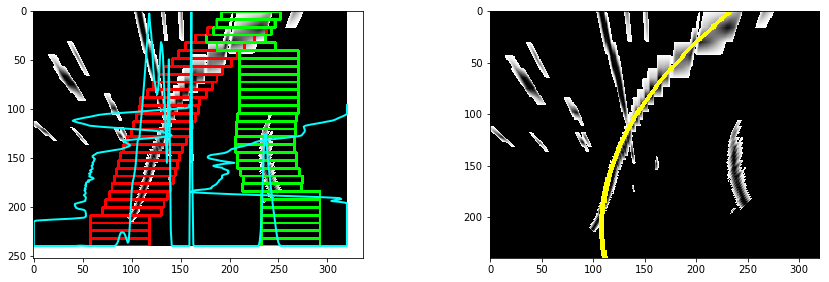

In [58]:
fig = plt.figure(figsize=(15, 10))
local_paths = img_paths[4:5]

i = 1
total = len(local_paths) * 2
cols = 2
for img_path in local_paths:
    print(img_path)
    a = fig.add_subplot((total/cols)+1, cols, i)
    img_raw = cv2.imread(img_path)
    img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

    warped = preprocess(img_raw, mtx, dist, M)
    print(warped.shape)
    finder = FindLinesSlidingWindows(nwindows=30, window_minpix=20, subsequent_search_margin=30,
                                     error_threshold=30, window_patience=7, window_empty_px=5,
                                     lr_start_slack=0.1, error_top_percentile=75, center_importance=4,
                                     debug=True, debug_dir='v', debug_show_lines=False, debug_error_detail=False)

    fits = finder.process(warped)

    final_img = annotate_with_lines(warped, fits)
    
    i += 1
    a = fig.add_subplot((total/cols)+1, cols, i)
    plt.imshow(final_img, cmap='gray')
    i += 1

test_images/blue2.jpg
line 1 error: 0.865727722849561
line 1 coefs: [ -1.09163250e-03   4.01136268e-01   9.60481194e+01]
line 2 error: 0.25178974978492813
line 2 coefs: [ -2.13890904e-03   1.03146994e+00   2.28534773e+02]
test_images/blue1.jpg
line 1 error: None (not included)
line 2 error: 0.18901830609151465
line 2 coefs: [ -1.26146901e-03   7.68165996e-01   1.25752336e+02]
test_images/yellow2.jpg
line 1 error: 0.4491383943632145
line 1 coefs: [ -3.85102725e-03   1.14271221e+00   2.82173920e+01]
line 2 error: 0.22223093518149667
line 2 coefs: [  9.72595566e-04   5.72813620e-01   1.31232879e+02]
test_images/green1.jpg
line 1 error: 23.947189149088747
line 1 coefs: [  2.62888816e-05  -2.06399868e-01   1.40713392e+02]
line 2 error: 0.22211266155863923
line 2 coefs: [  7.05259786e-03  -3.55098682e-01   2.01942438e+02]
test_images/middle.jpg
line 1 error: 0.18561212458186216
line 1 coefs: [  2.89512637e-03  -1.20795549e+00   2.34547661e+02]
line 2 error: 6.4078406138765445
line 2 coefs: [

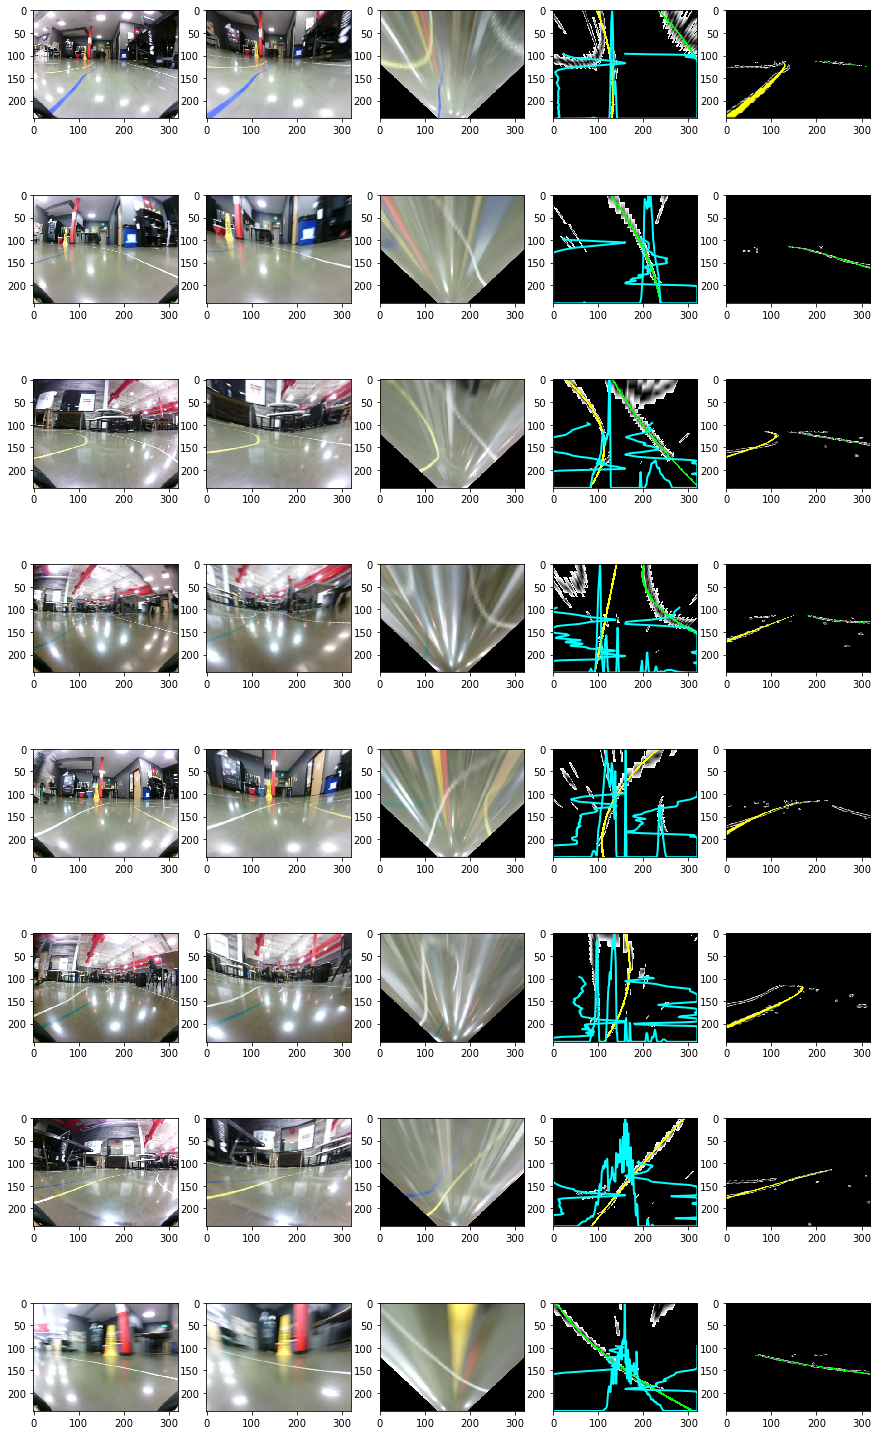

In [55]:
fig = plt.figure(figsize=(15, 30))
local_paths = img_paths

i = 1
total = len(local_paths)*5
cols = 5
for img_path in local_paths:
    print(img_path)
    img_raw = cv2.imread(img_path)
    img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    warped = cv2.warpPerspective(undist, M, img_size)

    # Display the original, undistorted, and warped image
    a = fig.add_subplot((total/cols)+1, cols, i)
    plt.imshow(img)
    i+=1
    a = fig.add_subplot((total/cols)+1, cols, i)
    plt.imshow(undist)
    i+=1
    a = fig.add_subplot((total/cols)+1, cols, i)
    plt.imshow(warped)
    i+=1
    
    # Find lines
    a = fig.add_subplot((total/cols)+1, cols, i)
    finder = FindLinesSlidingWindows(nwindows=30, window_minpix=20, subsequent_search_margin=30,
                                     lr_start_slack=0.1, debug=True, error_top_percentile=75,
                                     center_importance=4,
                                     error_threshold=30, window_patience=7, window_empty_px=5)
    preprocessed = preprocess(img_raw, mtx, dist, M)
    fits = finder.process(preprocessed)
    final_img = annotate_with_lines(preprocessed, fits, keep_background=True)
    plt.imshow(final_img)
    i += 1
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    a = fig.add_subplot((total/cols)+1, cols, i)
    final_img = cv2.warpPerspective(final_img, Minv, (final_img.shape[1], final_img.shape[0]))
    plt.imshow(final_img)
    i += 1

## Use blob to find lines

It does not work better than sliding windows, apparently.

test_images/yellow2.jpg
7
(240, 320)
shape 1
(1995, 2)
shape 2
(10018, 2)
shape 3
(151, 2)
shape 4
(560, 2)
shape 5
(15, 2)
shape 6
(11, 2)
total items: 10195
[[    0     0   320   240 64050]
 [   24     0    92   128  1995]
 [  114     0   163   182 10018]
 [  277   118    27    23   151]
 [   82   158    47    46   560]
 [  192   180     5     7    15]
 [  210   207     5     4    11]]
[[ 156.33851678  131.83812646]
 [  71.16641604   50.29373434]
 [ 198.06598123   50.4332202 ]
 [ 290.31125828  128.27152318]
 [ 108.62678571  184.60714286]
 [ 194.2         183.2       ]
 [ 212.27272727  208.63636364]]
[-96, -95, -94, -93, -92, -91, -90, -89, -88, -87, -86, -85, -84, -83, -82, -81, -80, -79, -78, -77, -76, -75, -74, -73, -72, -71, -70, -69, -68, -67, -66, -65, -64, -63, -62, -61, -60, -59, -59, -58, -57, -56, -55, -54, -53, -52, -51, -50, -49, -48, -47, -47, -46, -45, -44, -43, -42, -41, -40, -39, -39, -38, -37, -36, -35, -34, -33, -33, -32, -31, -30, -29, -28, -28, -27, -26, -25, -24, 

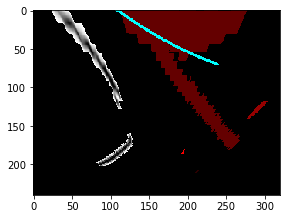

In [49]:
fig = plt.figure(figsize=(15, 10))
local_paths = img_paths[2:3]

i = 1
total = len(local_paths)
cols = 3
for img_path in local_paths:
    print(img_path)
    a = fig.add_subplot((total/cols)+1, cols, i)
    img_raw = cv2.imread(img_path)
    img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

    warped = preprocess(img_raw, mtx, dist, M)
    finder = FindLinesSlidingWindows(window_minpix=50, subsequent_search_margin=20,
                                     always_recalculate=True, debug=True)
    # You need to choose 4 or 8 for connectivity type
    connectivity = 4  
    # Perform the operation
    output = cv2.connectedComponentsWithStats(warped, connectivity)
    centroids = output[3]
    # Get the results
    # The first cell is the number of labels
    num_labels = output[0]
    print(num_labels)
    # The second cell is the label matrix
    labels = output[1]
    print(labels.shape)
    
    ylist = []
    xlist = []
    f3 = np.stack((warped, warped, warped), axis=2)
    f3 = (f3 * 255.0).astype(np.uint8)
    for label in range(1, num_labels):
        pos = np.argwhere(labels==label)
        print("shape", label)
        print(pos.shape)
        posx = pos[:, 0]
        posy = pos[:, 1]
        if centroids[label][0] > warped.shape[1]/2:
            f3[posx, posy] = ((label * 50), 0, 0)
            xlist += list(pos[:, 0])
            ylist += list(pos[:, 1])
            
    print("total items:", len(ylist))
    fit = np.polyfit(ylist, xlist, 2)
    fitx = []
    for y in range(warped.shape[0]):
        x = int(fit[0]*y**2 + fit[1]*y + fit[2])
        fitx.append(x)
    
    pts = np.array([np.transpose(np.vstack([[range(warped.shape[0])], fitx]))], np.int32)
    cv2.polylines(f3, np.int_([pts]), False, (0, 255, 255), thickness=2)
        
    # The third cell is the stat matrix
    stats = output[2]
    print(stats)
    # The fourth cell is the centroid matrix
    print(centroids)
    plt.imshow(f3)

    print(fitx)
#     lines = finder.process(warped)
#     final_img = annotate_with_lines(warped, lines)
#     plt.imshow(final_img, cmap='gray')

    i += 1

test_images/blue2.jpg


error: /home/travis/miniconda/conda-bld/conda_1486587069159/work/opencv-3.1.0/modules/imgproc/src/connectedcomponents.cpp:349: error: (-215) iDepth == CV_8U || iDepth == CV_8S in function connectedComponents_sub1


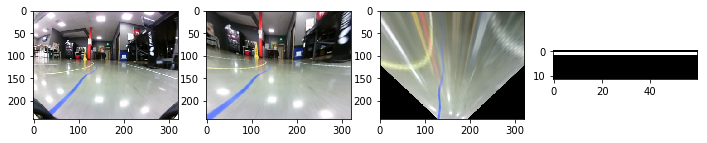

In [20]:
fig = plt.figure(figsize=(15, 30))
local_paths = img_paths

i = 1
total = len(local_paths)*5
cols = 5
for img_path in local_paths:
    print(img_path)
    img_raw = cv2.imread(img_path)
    img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    warped = cv2.warpPerspective(undist, M, img_size)

    # Display the original, undistorted, and warped image
    a = fig.add_subplot((total/cols)+1, cols, i)
    plt.imshow(img)
    i+=1
    a = fig.add_subplot((total/cols)+1, cols, i)
    plt.imshow(undist)
    i+=1
    a = fig.add_subplot((total/cols)+1, cols, i)
    plt.imshow(warped)
    i+=1
    
    # Find lines
    a = fig.add_subplot((total/cols)+1, cols, i)
    finder = FindLinesSlidingWindows(window_minpix=50, subsequent_search_margin=30,
                                     always_recalculate=True, debug=False)
    preprocessed = preprocess(img_raw, mtx, dist, M)
    lines = finder.process(preprocessed)
    final_img = annotate_with_lines(preprocessed, lines, keep_background=True)
    plt.imshow(final_img)
    i += 1
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    a = fig.add_subplot((total/cols)+1, cols, i)
    final_img = cv2.warpPerspective(final_img, Minv, (final_img.shape[1], final_img.shape[0]))
    plt.imshow(final_img)
    i += 1

In [ ]:
import cv2
import numpy as np

img = cv2.imread('test_images/green2.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,130,apertureSize = 3)
minLineLength = 10
maxLineGap = 5
lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)
for x1,y1,x2,y2 in lines[0]:
    cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)

plt.imshow(img)